In [1]:

!pip install pickle-mixin
!pip install tensorflow
!pip install keras
!pip install keras.layers.wrappers
!pip install keras.layers.merge
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers import Bidirectional
# from keras.layers.merge import add
from keras.layers import concatenate
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

  Preparing metadata (setup.py) ... done
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5991 sha256=e3395dc897539178005b1717db3c4faa16cb866754016af6a82e8d5f1ada0499
  Stored in directory: /root/.cache/pip/wheels/3e/c6/e9/d1b0a34e1efc6c3ec9c086623972c6de6317faddb2af0a619c
Successfully built pickle-mixin
ERROR: Could not find a version that satisfies the requirement keras.layers.wrappers (from versions: none)
ERROR: No matching distribution found for keras.layers.wrappers
ERROR: Could not find a version that satisfies the requirement keras.layers.merge (from versions: none)
ERROR: No matching distribution found for keras.layers.merge


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adibquader","key":"b1e8d284cb2e29b879f0cfe72ed5e0d0"}'}

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle datasets download -d shadabhussain/flickr8k

Dataset URL: https://www.kaggle.com/datasets/shadabhussain/flickr8k
License(s): unknown
 99% 2.12G/2.13G [00:17<00:00, 195MB/s]
100% 2.13G/2.13G [00:17<00:00, 127MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('flickr8k.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

zip_ref1 = zipfile.ZipFile('glove.6B.zip', 'r')
zip_ref1.extractall('/content/glove6b')
zip_ref1.close()

--2024-05-25 15:36:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-25 15:36:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-25 15:36:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:

token_path = "/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt"
train_images_path = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
test_images_path = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
images_path = '/content/Flickr_Data/Flickr_Data/Images/'
glove_path = '/content/glove6b/'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [8]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [9]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

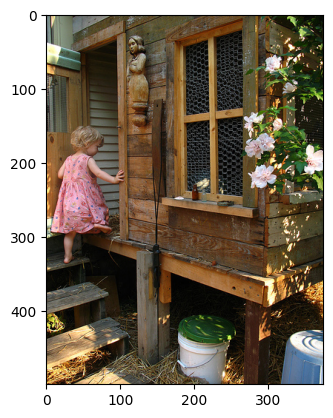

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [10]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [11]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [12]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [13]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [14]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img:
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img:
    if i[len(images_path):] in test_images:
        test_img.append(i)

In [15]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [16]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [17]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [18]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [19]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [20]:
embeddings_index = {}
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [21]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [22]:
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 1s 0us/step


In [23]:
model_new = Model(model.input, model.layers[-2].output)

In [24]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [25]:
def encode(image):
    image = preprocess(image)
    fea_vec = model_new.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step


In [26]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = concatenate([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 38)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 38, 200)              332000    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [27]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [29]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [30]:
epochs = 30
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
2000/2000 [==============================] - 273s 130ms/step - loss: 3.7011
Epoch 2/30
2000/2000 [==============================] - 269s 134ms/step - loss: 3.0409
Epoch 3/30
2000/2000 [==============================] - 255s 127ms/step - loss: 2.8377
Epoch 4/30
2000/2000 [==============================] - 255s 128ms/step - loss: 2.7168
Epoch 5/30
2000/2000 [==============================] - 252s 126ms/step - loss: 2.6305
Epoch 6/30
2000/2000 [==============================] - 250s 125ms/step - loss: 2.5684
Epoch 7/30
2000/2000 [==============================] - 252s 126ms/step - loss: 2.5167
Epoch 8/30
2000/2000 [==============================] - 248s 124ms/step - loss: 2.4739
Epoch 9/30
2000/2000 [==============================] - 256s 128ms/step - loss: 2.4396
Epoch 10/30
2000/2000 [==============================] - 255s 127ms/step - loss: 2.4072
Epoch 11/30
2000/2000 [==============================] - 255s 128ms/step - loss: 2.3807
Epoch 12/30
2000/2000 [==================

In [31]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [32]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

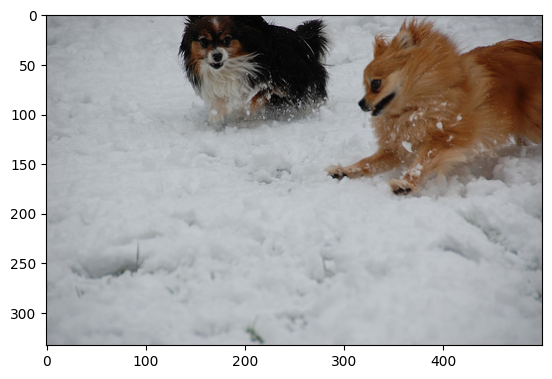

Greedy Search: a dog is running through the snow
Beam Search, K = 3: a brown and white dog runs through the snow
Beam Search, K = 5: a brown and white dog jumps over a pile of logs
Beam Search, K = 7: a brown and white dog jumps over a pile of logs
Beam Search, K = 10: a brown and white dog plays in the snow


In [33]:
pic = '2398605966_1d0c9e6a20.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))

In [36]:
# !pip install pyttsx3
# import pyttsx3
# engine = pyttsx3.init()

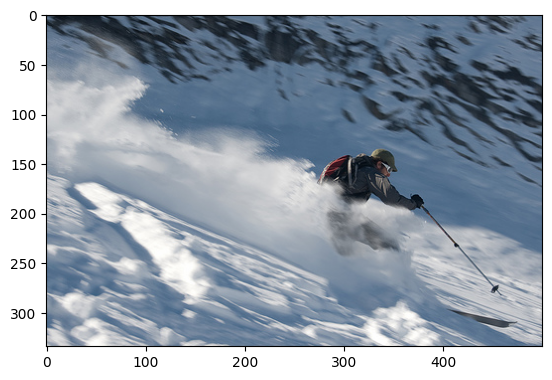

Greedy: a skier is jumping over a snowy mountain
Beam Search, K = 3: a skier flies through the air above the snowy mountains
Beam Search, K = 5: this person is skiing down a snowy mountain
Beam Search, K = 7: a skier flies through the air in the mountains


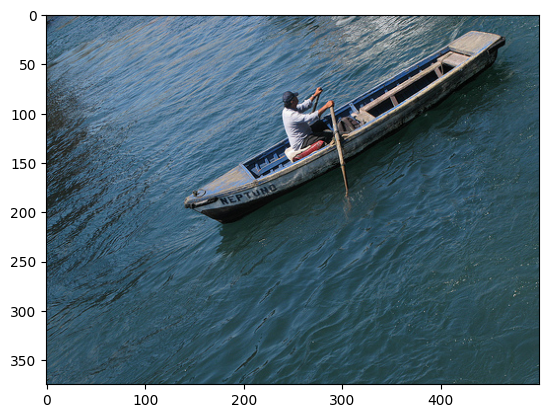

Greedy: a man paddles a canoe through the water
Beam Search, K = 3: a man paddles a canoe through the water
Beam Search, K = 5: a group of people are sitting on a dock in a boat paddle
Beam Search, K = 7: a group of people sit on the end of a boat looking out at the water


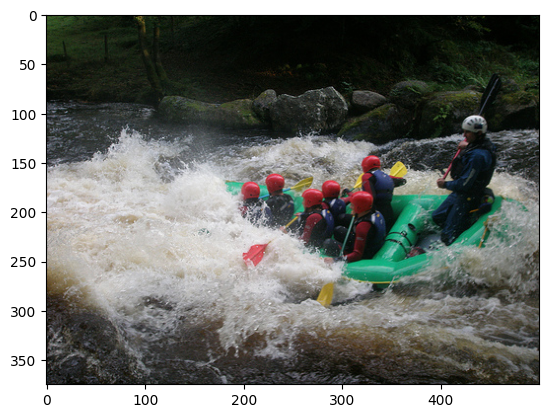

Greedy: a man in a yellow kayak is paddling through the rapids
Beam Search, K = 3: a man in a yellow kayak paddles down rapids
Beam Search, K = 5: a group of people in rafting gear sits on a surfboard in the water
Beam Search, K = 7: a group of people in rafting gear in the water


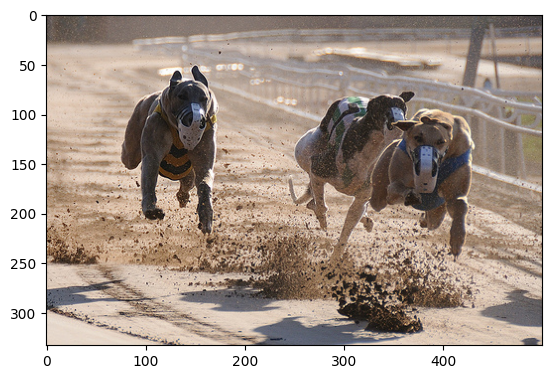

Greedy: two dogs are running through the dirt
Beam Search, K = 3: two white and brown dogs are pulling a sled in the woods
Beam Search, K = 5: two dogs play in the dirt
Beam Search, K = 7: muzzled greyhounds are racing on the track


In [56]:
tos=[110, 20, 500, 11]
for i in range(len(tos)):
  pic = list(encoding_test.keys())[tos[i]]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()

  print("Greedy:",greedySearch(image))
  print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
  print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
  print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))